# FMD Scorecard KPIs

## Setup

### Import packages

In [1]:
# workhorse modules
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import re
from pathlib import Path
import datadotworld as dw
import pyodbc 

# local utility functions
from utils import *
from private.config import config

### Set pandas options
This makes Pandas print all rows and columns to the output when requested.

In [2]:
set_pd_params()

pd.options.mode.chained_assignment = None  # default='warn'

### Import the data
Data is a copy of Archibus's `wrhwr` table, with some irrelevant columns left out. 

In [11]:
# Get private credentials using dotenv system
server = config["SERVER"]
user = config["USER"]
password = config["PASSWORD"]
db = config["DB"]

# Connect to Archibus database
conn = pyodbc.connect(f"DRIVER=ODBC Driver 17 for SQL Server;SERVER={server};DATABASE={db};UID={user};PWD={password}")
cursor = conn.cursor()

# Open a file with our basic SQL query
query_path = Path.cwd() / "sql" / "input_for_FMD_KPIs.sql"
fd = open(query_path, 'r')
sqlFile = fd.read()
fd.close()

# Query the database
kpis_raw = pd.read_sql(sqlFile, conn, parse_dates=['date_requested', 'date_completed', 'date_closed'] )
conn.close()

print(f"The KPIs raw dataframe has {kpis_raw.shape[0]:,} rows.")
kpis_raw.sample(3, random_state=444)

The KPIs raw dataframe has 133,070 rows.


,wo_id,date_requested,time_requested,date_completed,time_completed,date_closed,pmp_id,bl_id,cost_total,cost_labor,cost_parts,problem_type,requestor,supervisor,po_number,invoice_number,release_number,name,pmp_id,status
55591,42291,2015-08-05,1899-12-30 12:02:36,2015-08-10,1899-12-30 14:22:36,2015-08-21 00:00:00.000,None,B00163,0.0,0.0,0.0,BATHROOM_FIXT,MARTIN.POTTER,JIMMY.HOLTHAUS,None,None,None,The Weinberg Housing and Resource Center,None,Clo
16261,8202,2014-04-01,1899-12-30 11:45:10,2014-04-01,1899-12-30 11:46:07,2014-04-02 00:00:00.000,None,B00056,0.0,0.0,0.0,SERV/CUSTODIAL,JIMMY.HOLTHAUS,JIMMY.HOLTHAUS,None,None,None,City Hall,None,Clo
120150,123381,2019-08-08,1899-12-30 11:27:30,2019-10-01,1899-12-30 09:08:49,2020-03-26 11:04:05.183,None,B00050,0.0,0.0,0.0,FLOOR,JAY.STURGIS,CHARLES.CLARIDY,None,None,None,Charles L. Benton Jr. Building,None,Clo


## Data cleaning

### Basic cleaning
- removes white spaces in strings to facilitate matching, 
- drops rows with no problem type, 
- renames a few columns

In [27]:
def tidy_up_wr(df):
    df = df.copy()
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.dropna(subset=["wo_id", "problem_type"])
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df["wo_id"] = df["wo_id"].astype(int).astype(str)
    cond_valid = ~df["problem_type"].str.contains("TEST")
    df = df[cond_valid]
    df["status"] = df["status"].replace("A", "AA", regex=False)
    return df

# apply the tidy up function
wr_tidy = tidy_up_wr(kpis_raw)

print(f"The tidied work orders dataframe has {wr_tidy.shape[0]:,} rows.")

The tidied work orders dataframe has 132,543 rows.


### Fix repeated ID numbers

In [28]:
def unique_ids(df):
    df = df.copy()
    df = df.sort_values(['wo_id', 'supervisor'])
    df = df.drop_duplicates(subset=['wo_id', 'date_requested'], keep='first')
    return df
    
wr_unique_ids = unique_ids(wr_tidy)

print(f"The tidied work orders dataframe has {wr_unique_ids.shape[0]:,} rows.")
#print(wr_unique_ids.info())
wr_unique_ids.sample(3, random_state=444)

The tidied work orders dataframe has 102,430 rows.


,wo_id,date_requested,time_requested,date_completed,time_completed,date_closed,pmp_id,bl_id,cost_total,cost_labor,cost_parts,problem_type,requestor,supervisor,po_number,invoice_number,release_number,name,status
97600,96794,2017-12-20,1899-12-30 14:41:52,2017-12-28,1899-12-30 11:14:39,2018-01-11 11:45:38.417,None,B00163,0.0,0.0,0.0,PREVENTIVE MAINT,MARTIN.POTTER,JIMMY.HOLTHAUS,None,None,None,The Weinberg Housing and Resource Center,Clo
1106,568,2013-10-29,1899-12-30 07:29:53,2013-10-29,1899-12-30 07:54:17,2013-10-29 00:00:00.000,None,B00021,0.0,0.0,0.0,OTHER,CHARLES.CLARIDY,None,None,None,None,Baltimore City Police Headquarters Annex,Clo
23924,12125,2014-06-23,1899-12-30 14:30:55,2014-06-23,1899-12-30 14:31:40,2014-06-23 00:00:00.000,None,B00062,0.0,0.0,0.0,OTHER,JIMMY.HOLTHAUS,JIMMY.HOLTHAUS,None,None,None,Elijah E. Cummings Courthouse and Old Post Office,Clo


### Remove duplicate work orders
Removes rows where technician says WR is a duplicate in the description, and the status is "Canceled", "Closed", or "Rejected". 

In [29]:
# wr_deduped = drop_dupes(wr_unique_ids)
wr_deduped = wr_unique_ids.copy()
# print(f"The deduped work orders dataframe has {wr_deduped.shape[0]:,} rows.")
# print(
#     f"Removing duplicates has cut {wr_tidy.shape[0] - wr_deduped.shape[0]:,} rows from the work orders dataframe."
# )

### Combine date and time columns to get timestamps
This takes the date from a date column and the time from a time column and combines them into a single timestamp.

This transformation allows us to know the time to completion with greater precision. 

In [31]:
# glue the date and time for request
wr_dt = glue_date_time(wr_deduped, "date_requested", "time_requested", "requested_dt")

# glue the date and time for completion
wr_dt = glue_date_time(wr_dt, "date_completed", "time_completed", "completed_dt")

# convert "date closed" to date time (this column has no time information)
wr_dt["date_closed"] = wr_dt["date_closed"].astype("datetime64")

wr_dt[["wo_id", "requested_dt", "completed_dt", "date_closed"]].sample(3)

,wo_id,requested_dt,completed_dt,date_closed
123319,126683,2019-11-04 09:56:13,2019-11-06 08:28:47,2020-03-24 08:26:10.187
77177,74751,2016-09-28 10:05:49,2016-09-28 10:39:52,2016-09-29 06:28:43.980
114123,113969,2019-01-15 12:07:47,2019-01-25 10:52:42,2019-07-15 10:15:44.577


## Data preparation

### Include days to completion

In [20]:
wr_durations = compute_days_to_completion(wr_dt)

In [22]:
wr_durations[
    ["wr_id", "problem_type", "requested_dt", "completed_dt", "days_to_completion"]
].sample(6, random_state=444)

,wr_id,problem_type,requested_dt,completed_dt,days_to_completion
requested_dt,,,,,
2018-08-13 11:16:06,109375,OTHER,2018-08-13 11:16:06,2018-09-05 11:45:26,23.02
2015-08-04 14:45:02,42258,SERV/CUSTODIAL,2015-08-04 14:45:02,2015-08-04 14:46:16,0.00
2015-07-22 16:32:12,41664,ELEC/LIGHT,2015-07-22 16:32:12,2015-07-27 07:52:24,4.64
2014-05-13 17:16:04,10292,HVAC,2014-05-13 17:16:04,NaT,NaN
2016-09-23 15:25:57,75334,CEILTILE,2016-09-23 15:25:57,NaT,NaN
2019-01-18 11:27:20,115369,WINDOW,2019-01-18 11:27:20,2019-02-04 06:04:51,16.78


### Decision point: fiscal year
Note that the function `entirely_within_fiscal_year()` keeps only those rows where the work order was requested and closed in the same fiscal year. __Other rows that straddle two fiscal years are dropped__.

For comparison, I've included the function `add_fiscal_year()`, which derives the fiscal year from the request date and drops no rows.

In [90]:
wr_fy = entirely_within_fiscal_year(wr_durations)
# wr_fy = add_fiscal_year(wr_durations)

print(
    f"Limiting analysis to work orders entirely within one FY drops {len(wr_durations) - len(wr_fy):,} rows from the data."
)

wr_fy[
    [
        "wr_id",
        "problem_type",
        "days_to_completion",
        "requested_dt",
        "completed_dt",
        "date_closed",
        "fiscal_year",
    ]
].sample(6, random_state=444)

Limiting analysis to work orders entirely within one FY drops 33,578 rows from the data.


,wr_id,problem_type,days_to_completion,requested_dt,completed_dt,date_closed,fiscal_year
requested_dt,,,,,,,
2015-10-07 12:56:41,53264,HVAC,43.97,2015-10-07 12:56:41,2015-11-20 12:12:11,2015-12-03 13:20:44.220,2016
2014-08-29 11:40:11,15003,HVAC,0.00,2014-08-29 11:40:11,2014-08-29 11:43:00,2014-08-29 00:00:00.000,2015
2015-07-21 09:10:56,41558,OTHER,0.01,2015-07-21 09:10:56,2015-07-21 09:29:24,2015-08-02 00:00:00.000,2016
2018-09-21 11:11:15,111134,PLUMB/UNCLOG,2.85,2018-09-21 11:11:15,2018-09-24 07:37:02,2018-09-26 13:07:34.060,2019
2017-10-17 11:08:45,94992,LOCK,0.00,2017-10-17 11:08:45,2017-10-17 11:10:10,2017-10-20 08:43:22.557,2018
2016-12-21 12:03:46,80359,_DELIVERY,0.91,2016-12-21 12:03:46,2016-12-22 09:47:21,2017-01-06 15:11:49.823,2017


### Filter to PM only, and for relevant fiscal years only

In [91]:
PM_list = [
    "HVAC|PM",
    "BUILDING|PM",
    "PREVENTIVE MAINT",
    "FUEL INSPECTION",
    "BUILDING INTERIOR INSPECTION",
    "INSPECTION",
    "FUEL INSPECTION",
]

cond_fy = wr_fy["fiscal_year"].isin(range(2016, 2021))
cond_pm = wr_fy["problem_type"].isin(PM_list)

wr_filtered = wr_fy[cond_fy & cond_pm]

print(f"The filtered work orders dataframe has {wr_filtered.shape[0]:,} rows.")

The filtered work orders dataframe has 4,194 rows.


## KPI: % PMs completed on time 
The goal here is to filter the data down to preventive maintenance only, and then show how many are completed before a given benchmark.

### Reproduce last year's work

#### Define the years of the benchmark period

In [93]:
cond_benchmark = wr_filtered["fiscal_year"].isin(range(2015, 2019))
print(
    f"The on-time benchmark will be computing using only rows from years {list(wr_filtered[cond_test]['fiscal_year'].unique())}"
)

The on-time benchmark will be computing using only rows from years [2016, 2017, 2018]


#### Compute the benchmark and add 'is_on_time' column

In [94]:
on_time_benchmark = wr_filtered[cond_benchmark]["days_to_completion"].median()
print(f"PM work orders are on time if completed within {on_time_benchmark} days.")


def compute_is_on_time(df, benchmark):
    df = df.copy()
    df["is_on_time"] = df["days_to_completion"] <= benchmark
    return df


wr_on_time = compute_is_on_time(wr_filtered, on_time_benchmark)

PM work orders are on time if completed within 10.74 days.


#### Group by fiscal year and get % on time

In [95]:
wr_on_time.groupby("fiscal_year")[["is_on_time"]].mean().round(2)

,is_on_time
fiscal_year,
2016,0.41
2017,0.37
2018,0.66
2019,0.78
2020,0.25


Note that there are some __large differences__ between the results reported last year and the results we get here. For reference, this is what DGS reported last year:


| Year|Last year's reported result|New computed result|
|---|---|---|
|2016 |61|41|
|2017|49|37|
|2018|66|66|
|2019|73|78|

### Compute this year's results
We move the benchmarking period forward by one year. That gives us a slightly lower benchmark.

In [96]:
cond_new_benchmark = wr_filtered["fiscal_year"].isin(range(2016, 2020))
on_time_benchmark = wr_filtered[cond_new_benchmark]["days_to_completion"].median()
print(f"PM work orders are on time if completed within {on_time_benchmark} days.")

wr_on_time = compute_is_on_time(wr_filtered, on_time_benchmark)

PM work orders are on time if completed within 9.04 days.


In [98]:
wr_on_time.groupby("fiscal_year")[["is_on_time"]].mean()

,is_on_time
fiscal_year,
2016,0.326284
2017,0.361831
2018,0.618327
2019,0.760125
2020,0.231432


## KPI: % of preventative maintenance out of HVAC work orders

The two lists below contain the exact same problem types mentioned in last year's scorecard. So we would expect to be able to replicate last year's results closely.

In [71]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "HVAC|PM",
    "PREVENTIVE MAINT",
    # "BUILDING|PM",
    # "FUEL INSPECTION",
    # "BUILDING INTERIOR INSPECTION",
    # "INSPECTION",
]

### Filter to HVAC rows only

In [99]:
cond_cm = wr_fy["problem_type"].isin(CM_list)
cond_pm = wr_fy["problem_type"].isin(PM_list)

wr_HVAC = wr_fy[cond_cm | cond_pm]

print(f"We've gone from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows.")

We've gone from 69,357 rows to 12,979 rows.


### Compute all PM/CM stats by fiscal year

In [126]:
def compute_pm_cm(df, PM_list):
    df = df.copy().sort_values("fiscal_year")
    df["is_pm"] = df["problem_type"].isin(PM_list)
    results_df = pd.DataFrame(
        columns=[
            "year",
            "percent_pm",
            "pm_cm_ratio",
            "count_cm",
            "count_pm",
            "count_hvac",
        ]
    )
    for year in df["fiscal_year"].unique():
        results_dict = {}
        df_fy = df[df["fiscal_year"] == year]
        count_pm = len(df_fy[df_fy["problem_type"].isin(PM_list)])
        count_hvac = len(df_fy)
        count_cm = count_hvac - count_pm
        results_dict["year"] = year
        results_dict["percent_pm"] = (count_pm / count_hvac) * 100
        results_dict["pm_cm_ratio"] = count_pm / count_cm
        results_dict["count_pm"] = count_pm
        results_dict["count_cm"] = count_cm
        results_dict["count_hvac"] = count_hvac
        results_df = results_df.append(results_dict, ignore_index=True)
    results_df[["year", "count_cm", "count_pm", "count_hvac"]] = results_df[
        ["year", "count_cm", "count_pm", "count_hvac"]
    ].astype(int)
    return results_df.round(2)


pm_cm_results = compute_pm_cm(wr_HVAC, PM_list)

In [127]:
cond_complete_FY = pm_cm_results['year'] <= 2020
pm_cm_results = pm_cm_results[cond_complete_FY]

pm_cm_results

,year,percent_pm,pm_cm_ratio,count_cm,count_pm,count_hvac
0,2014,0.00,0.00,972,0,972
1,2015,3.53,0.04,1366,50,1416
2,2016,35.75,0.56,1190,662,1852
3,2017,41.56,0.71,1628,1158,2786
4,2018,46.33,0.86,1302,1124,2426
5,2019,26.01,0.35,913,321,1234
6,2020,44.81,0.81,1144,929,2073


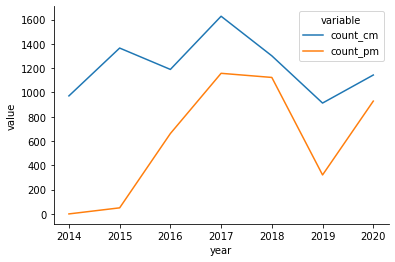

In [128]:
count_plot_data = pd.melt(pm_cm_results, id_vars=['year'], value_vars=['count_cm', 'count_pm'])

sns.lineplot(data=count_plot_data, y='value', x='year', hue='variable')

sns.despine()

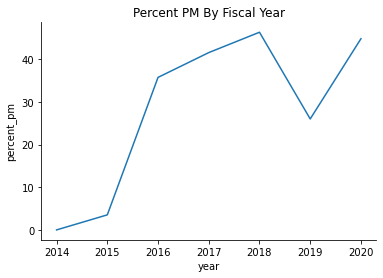

In [129]:
ax = sns.lineplot(data=pm_cm_results, y='percent_pm', x='year',)
ax.set(title = "Percent PM By Fiscal Year")
sns.despine()